- [x] GH Filters
- [x] The Discrete Bayes Filter
- [x]  Probabilities, Gaussians, and Bayes' Theorem
- [ ]  One Dimensional Kalman Filters
- [ ] Multivariate Gaussians
- [ ] Multivariate Kalman Filter
- [ ]  Kalman Filter Math
- [ ]  Designing Kalman Filters 

##### **The key insight to this entire book is in the next paragraph. Read it carefully!**

So what do we do? If we only form estimates from the measurement then the prediction will not affect the result. If we only form estimates from the prediction then the measurement will be ignored. If this is to work we need to take some kind of **blend of the prediction and measurement** (I've bolded the key point).

---
Now let's try a randomly chosen number to scale our estimate: $\frac{4}{10}$. Our estimate will be four tenths the measurement and the rest will be from the prediction. In other words, we are expressing a belief here, a belief that the prediction is somewhat more likely to be correct than the measurement. We compute that as

$$
\mathtt{estimate} = \mathtt{prediction} + \frac{4}{10}(\mathtt{measurement} - \mathtt{prediction})
$$ 


This algorithm is known as the [g-h filter](https://en.wikipedia.org/wiki/Alpha_beta_filter) or the $\alpha$-$\beta$ filter. $g$ and $h$ refer to the two scaling factors that we used in our example. $g$ is the scaling we used for the measurement (weight in our example), and $h$ is the scaling for the change in measurement over time (lbs/day in our example). $\alpha$ and $\beta$ are just different names used for this factors. the Kalman filter is a form of the g-h filter

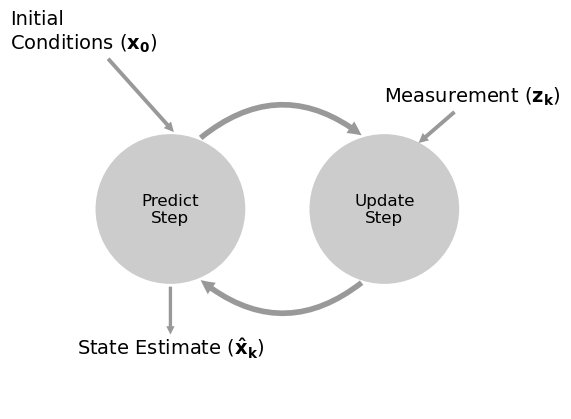

#### Algorithm


**Initialization**

    1. Initialize the state of the filter
    2. Initialize our belief in the state

**Predict**

    1. Use system behavior to predict state at the next time step
    2. Adjust belief to account for the uncertainty in prediction
    
**Update**

    1. Get a measurement and associated belief about its accuracy
    2. Compute residual between estimated state and measurement
    3. New estimate is somewhere on the residual lines.$$

In [101]:
import numpy as np
import matplotlib.pyplot as plt
def g_h_filter(data, x0, dx, g, h, dt):
    """
    Performs g-h filter on 1 state variable with a fixed g and h.

    'data' contains the data to be filtered.
    'x0' is the initial value for our state variable
    'dx' is the initial change rate for our state variable
    'g' is the g-h's g scale factor
    'h' is the g-h's h scale factor
    'dt' is the length of the time step 
    """
    x_est = x0
    results = []
    for z in data:
        # prediction step
        x_pred = x_est + (dx*dt)
        dx = dx

        # update step
        residual = z - x_pred
        dx = dx + h * (residual) / dt
        x_est = x_pred + g * residual
        results.append(x_est)
    return np.array(results)



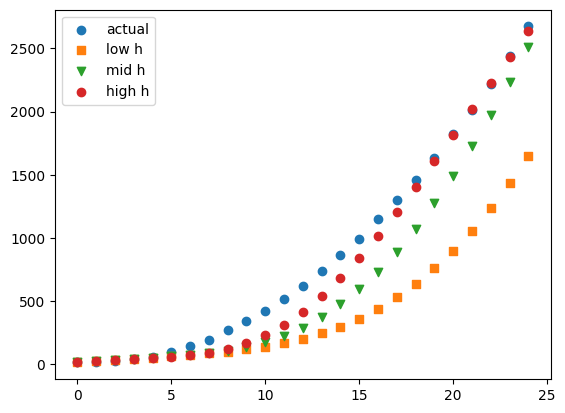

In [166]:
COUNT=25
actual_weights = np.array([5*x**2-10.*x+20. for x in range(COUNT)])
actual_weights += np.random.normal(0, 1, COUNT)*(COUNT**.5)

plt.scatter(range(COUNT),actual_weights, label="actual")
plt.scatter(range(COUNT),g_h_filter(data=actual_weights, x0=5., dx=10., g=.0, h=.02, dt=1), marker='s', label="low h")
plt.scatter(range(COUNT),g_h_filter(data=actual_weights, x0=5., dx=10., g=.0, h=.05, dt=1),  marker='v', label="mid h")
plt.scatter(range(COUNT),g_h_filter(data=actual_weights, x0=5., dx=10., g=.0, h=.1, dt=1),  marker='o', label="high h")
plt.legend()

# NOTE: However this trend insignificant as more and more data 
# gets available simulate that by increasing COUNT

when there is a sharp, stable change in the actual value, `g` helps stablize it. However when consistent rise acceleration, `h` value maintains it

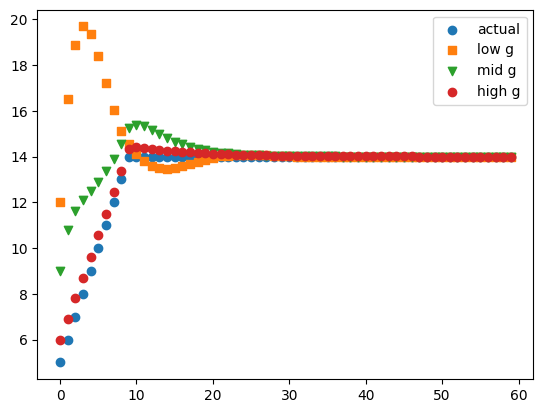

In [171]:
actual_weights = [5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
for i in range(50):
    actual_weights.append(14)
COUNT=len(actual_weights)
predictions = g_h_filter(data=actual_weights, x0=5., dx=10., g=.5, h=.1, dt=.5)
plt.scatter(range(COUNT),actual_weights, label="actual")
plt.scatter(range(COUNT),g_h_filter(data=actual_weights, x0=5., dx=10., g=.3, h=.1, dt=1), marker='s', label="low g")
plt.scatter(range(COUNT),g_h_filter(data=actual_weights, x0=5., dx=10., g=.6, h=.1, dt=1),  marker='v', label="mid g")
plt.scatter(range(COUNT),g_h_filter(data=actual_weights, x0=5., dx=10., g=.9, h=.1, dt=1),  marker='o', label="high g")
plt.legend()

### Discreate Bayes Filter
The Kalman filter belongs to a family of filters called *Bayesian filters*. Most textbook treatments of the Kalman filter present the Bayesian formula, perhaps shows how it factors into the Kalman filter equations, but mostly keeps the discussion at a very abstract level. 

In [255]:
import numpy as np
belief = np.array([1/10]*10) # also known as prior in bayesian statistics (say if every position is equally likely)
# print(belief)
hallway = np.array([1, 1, 0, 0, 0, 0, 0, 0, 1, 0]) # 1 for doors, 0 for walls
#belief = hallway / np.sum(hallway) # each door way is equally likely
# plt.bar(range(10), belief)

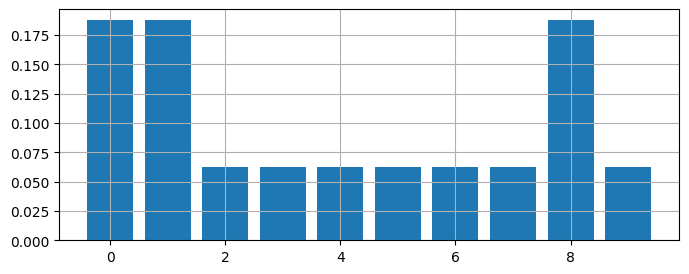

In [256]:
def update_belief(hallway, belief, z, z_prob):
    """ Update belief based on sensor data. set prior based on sensor reading
        z: position
        z_prob: reading odds
    """
    scale = z_prob / (1. - z_prob)
    belief[hallway==z] *= scale
update_belief(hallway, belief, z=1, z_prob=.75)
belief = belief / np.sum(belief) # normalizing to make total prior odds equal 1

plt.figure(figsize=(8,3))
plt.bar(range(10), belief)
plt.grid()

[*likelihood*](https://en.wikipedia.org/wiki/Likelihood_function)/ [*posterior*](https://en.wikipedia.org/wiki/Posterior_probability). When we computed `belief[hall==z] *= scale` we were computing how *likely* each position was given the measurement. The likelihood is not a probability distribution because it does not sum to one.

The combination of these gives the equation

$$\mathtt{posterior} = \frac{\mathtt{likelihood} \times \mathtt{prior}}{\mathtt{normalization}}$$ 

When we talk about the filter's output we typically call the state after performing the prediction the *prior* or *prediction*, and we call the state after the update either the *posterior* or the *estimated state*. 

It is very important to learn and internalize these terms as most of the literature uses them extensively.



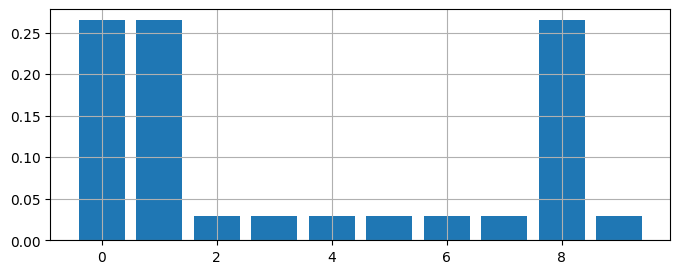

In [257]:
def update(likelihood, prior):
    normalize = lambda x: x/np.sum(x)
    return normalize(likelihood * prior)

def update_belief(hallway, belief, z, z_prob):
    """ Update belief based on sensor data. set prior based on sensor reading
        z: position
        z_prob: reading odds
    """
    scale = z_prob / (1. - z_prob)
    belief[hallway==z] *= scale
update_belief(hallway, belief, z=1, z_prob=.75)
belief = belief / np.sum(belief) # normalizing to make total prior odds equal 1

plt.figure(figsize=(8,3))
plt.bar(range(10), belief)
plt.grid()

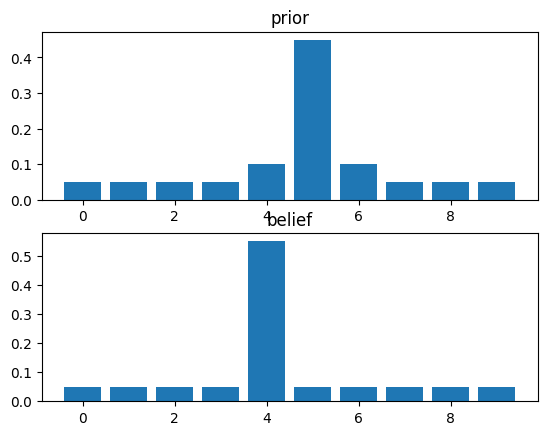

In [258]:
def predict_move_convolution(pdf, offset, kernel):
    N = len(pdf)
    kN = len(kernel)
    width = int((kN - 1) / 2)

    prior = np.zeros(N)
    for i in range(N):
        for k in range (kN):
            index = (i + (width-k) - offset) % N
            prior[i] += pdf[index] * kernel[k]
    return prior

belief = [.05, .05, .05, .05, .55, .05, .05, .05, .05, .05]
prior = predict_move_convolution(belief, offset=1, kernel=[.1, .8, .1])
fig, ax = plt.subplots(nrows=2, ncols=1)
ax[0].bar(range(10), prior)
ax[0].set_title("prior")
ax[1].bar(range(10), belief)
ax[1].set_title("belief")
plt.show()
# len(prior)

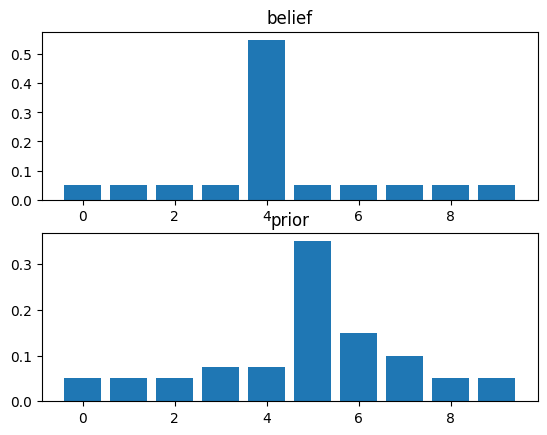

In [259]:
prior = predict_move_convolution(belief, offset=1, kernel=[.05, .05, .6, .2, .1])
fig, ax = plt.subplots(nrows=2, ncols=1)
ax[1].bar(range(10), prior)
ax[1].set_title("prior")
ax[0].bar(range(10), belief)
ax[0].set_title("belief")
plt.show()

In [260]:
class Train(object):

    def __init__(self, track_len, kernel=[1.], sensor_accuracy=.9):
        self.track_len = track_len
        self.pos = 0
        self.kernel = kernel
        self.sensor_accuracy = sensor_accuracy

    def move(self, distance=1):
        """ move in the specified direction
        with some small chance of error"""

        self.pos += distance
        # insert random movement error according to kernel
        r = random.random()
        s = 0
        offset = -(len(self.kernel) - 1) / 2
        for k in self.kernel:
            s += k
            if r <= s:
                break
            offset += 1
        self.pos = int((self.pos + offset) % self.track_len)
        return self.pos

    def sense(self):
        pos = self.pos
         # insert random sensor error
        if random.random() > self.sensor_accuracy:
            if random.random() > 0.5:
                pos += 1
            else:
                pos -= 1
        return pos

$$ \mathtt{posterior} = \frac{\mathtt{likelihood}\times \mathtt{prior}}{\mathtt{normalization\, factor}}$$ 

### Probs, Gaussian

The [*expected value*](https://en.wikipedia.org/wiki/Expected_value) of a random variable is the average value it would have if we took an infinite number of samples of it and then averaged those samples
Eg. What is the expected value of a die roll?

### Solution

Each side is equally likely, so each has a probability of 1/6. Hence
$$\begin{aligned}
\mathbb E[X] &= 1/6\times1 + 1/6\times 2 + 1/6\times 3 + 1/6\times 4 + 1/6\times 5 + 1/6\times6 \\
&= 1/6(1+2+3+4+5+6)\\&= 3.5\end{aligned}$$

## Gaussian Distributions

A Gaussian is a *continuous probability distribution* that is completely described with two parameters, the mean ($\mu$) and the variance ($\sigma^2$). It is defined as:

$$ 
f(x, \mu, \sigma) = \frac{1}{\sigma\sqrt{2\pi}} \exp\big [{-\frac{(x-\mu)^2}{2\sigma^2} }\big ]
$$

## The  68-95-99.7 Rule

It is worth spending a few words on standard deviation now. The standard deviation is a measure of how much the data deviates from the mean. For Gaussian distributions, 68% of all the data falls within one standard deviation ($\pm1\sigma$) of the mean, 95% falls within two standard deviations ($\pm2\sigma$), and 99.7% within three ($\pm3\sigma$). This is often called the [68-95-99.7 rule](https://en.wikipedia.org/wiki/68%E2%80%9395%E2%80%9399.7_rule). If you were told that the average test score in a class was 71 with a standard deviation of 9.4, you could conclude that 95% of the students received a score between 52.2 and 89.8 if the distribution is normal (that is calculated with $71 \pm (2 * 9.4)$). 

Finally, these are not arbitrary numbers. If the Gaussian for our position is $\mu=22$ meters, then the standard deviation also has units meters. Thus $\sigma=0.2$ implies that 68% of the measurements range from 21.8 to 22.2 meters. Variance is the standard deviation squared, thus $\sigma^2 = .04$ meters$^2$. As you saw in the last section, writing $\sigma^2 = 0.2^2$ can make this somewhat more meaningful, since the 0.2 is in the same units as the data.
![image.png](attachment:b5c86a0e-c8be-4332-9064-bf3c8bc10e45.png)

The product of two independent Gaussians is given by:

$$\begin{aligned}\mu &=\frac{\sigma_1^2\mu_2 + \sigma_2^2\mu_1}{\sigma_1^2+\sigma_2^2}\\
\sigma^2 &=\frac{\sigma_1^2\sigma_2^2}{\sigma_1^2+\sigma_2^2} 
\end{aligned}$$

The sum of two Gaussian random variables is given by

$$\begin{gathered}\mu = \mu_1 + \mu_2 \\
\sigma^2 = \sigma^2_1 + \sigma^2_2
\end{gathered}$$

## Limitations of Using Gaussians to Model the World

Earlier I mentioned the *central limit theorem*, which states that under certain conditions the arithmetic sum of any independent random variable will be normally distributed, regardless of how the random variables are distributed. This is important to us because nature is full of distributions which are not normal, but when we apply the central limit theorem over large populations we end up with normal distributions. 

However, a key part of the proof is “under certain conditions”. These conditions often do not hold for the physical world. For example, a kitchen scale cannot read below zero, but if we represent the measurement error as a Gaussian the left side of the curve extends to negative infinity, implying a very small chance of giving a negative reading. 

This is a broad topic which I will not treat exhaustively. 

Let's consider a trivial example. We think of things like test scores as being normally distributed. If you have ever had a professor “grade on a curve” you have been subject to this assumption. But of course test scores cannot follow a normal distribution. This is because the distribution assigns a nonzero probability distribution for *any* value, no matter how far from the mean. So, for example, say your mean is 90 and the standard deviation is 13. The normal distribution assumes that there is a large chance of somebody getting a 90, and a small chance of somebody getting a 40. However, it also implies that there is a tiny chance of somebody getting a grade of -10, or 150. It assigns an extremely small chance of getting a score of $-10^{300}$ or $10^{32986}$. The tails of a Gaussian distribution are infinitely long.

But for a test we know this is not true. Ignoring extra credit, you cannot get less than 0, or more than 100. Let's plot this range of values using a normal distribution to see how poorly this represents real test scores distributions.